#Jenkins Time Series Analysis

## Data Preprocessing


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [5]:
import pandas as pd
import re

def clean_timestamp(ts):
    """ Remove ordinal indicators from timestamp strings only when they follow a number """
    return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', ts)

def load_and_preprocess(file_name, timestamp_col, rename_dict, time_format):
    """ Load and preprocess a CSV file """
    df = pd.read_csv(file_name)
    print(f"Columns in {file_name}: {df.columns}")
    df = df.rename(columns=rename_dict)
    df['timestamp'] = df[timestamp_col].apply(clean_timestamp)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=time_format)
    return df

# Load daily logs
daily_files = [f'daily_log{i}.csv' for i in range(1, 5)]
daily_rename_dict = {
    '@timestamp per day': 'timestamp',
    'buildDefinitionId.keyword: Descending': 'pipeline_id',
    'Count': 'count'
}
daily_data = [load_and_preprocess(file, 'timestamp', daily_rename_dict, '%B %d %Y, %H:%M:%S.%f') for file in daily_files]

# Load weekly logs
weekly_files = [f'weekly_log{i}.csv' for i in range(1, 3)]
weekly_rename_dict = {
    '@timestamp per week': 'timestamp',
    'usageMetrics.exec_id.keyword: Descending': 'pipeline_id',
    'Count': 'count',
    'Last usageMetrics.available_cpu_cores': 'available_cpu_cores',
    'Last usageMetrics.guaranteed_cpu_cores': 'guaranteed_cpu_cores',
    'Last usageMetrics.used_cpu_cores': 'used_cpu_cores',
    'Last usageMetrics.max_cpu_cores': 'max_cpu_cores'
}
weekly_data = [load_and_preprocess(file, 'timestamp', weekly_rename_dict, '%B %d %Y, %H:%M:%S.%f') for file in weekly_files]

# Combine all daily data
daily_combined = pd.concat(daily_data, ignore_index=True)

# Combine all weekly data
weekly_combined = pd.concat(weekly_data, ignore_index=True)

# If needed, save combined data to a CSV file
daily_combined.to_csv('daily_combined_data.csv', index=False)
weekly_combined.to_csv('weekly_combined_data.csv', index=False)

print("Daily Data:")
print(daily_combined.head())

print("Weekly Data:")
print(weekly_combined.head())

Columns in daily_log1.csv: Index(['@timestamp per day', 'buildDefinitionId.keyword: Descending', 'Count'], dtype='object')
Columns in daily_log2.csv: Index(['@timestamp per day', 'buildDefinitionId.keyword: Descending', 'Count'], dtype='object')
Columns in daily_log3.csv: Index(['@timestamp per day', 'buildDefinitionId.keyword: Descending', 'Count'], dtype='object')
Columns in daily_log4.csv: Index(['@timestamp per day', 'buildDefinitionId.keyword: Descending', 'Count'], dtype='object')
Columns in weekly_log1.csv: Index(['@timestamp per week', 'usageMetrics.exec_id.keyword: Descending',
       'Count', 'Last usageMetrics.available_cpu_cores',
       'Last usageMetrics.guaranteed_cpu_cores',
       'Last usageMetrics.used_cpu_cores', 'Last usageMetrics.max_cpu_cores'],
      dtype='object')
Columns in weekly_log2.csv: Index(['@timestamp per week', 'usageMetrics.exec_id.keyword: Descending',
       'Count', 'Last usageMetrics.available_cpu_cores',
       'Last usageMetrics.guaranteed_cpu

In [8]:
# Load daily and weekly data
daily_combined = pd.read_csv('daily_combined_data.csv', parse_dates=['timestamp'])
weekly_combined = pd.read_csv('weekly_combined_data.csv', parse_dates=['timestamp'])

# Clean timestamps and ensure they are in the correct format
daily_combined['timestamp'] = pd.to_datetime(daily_combined['timestamp'])
weekly_combined['timestamp'] = pd.to_datetime(weekly_combined['timestamp'])

# Set timestamps as index
daily_combined.set_index('timestamp', inplace=True)
weekly_combined.set_index('timestamp', inplace=True)

# Fill missing values or handle anomalies
daily_combined['count'].fillna(0, inplace=True)
weekly_combined['count'].fillna(0, inplace=True)
# Resample daily data to ensure consistency (fill missing dates with 0 counts)
daily_ts = daily_combined['count'].resample('D').sum()

# Resample weekly data to ensure consistency (fill missing dates with 0 counts)
weekly_ts = weekly_combined['count'].resample('W').sum()


## Visualization

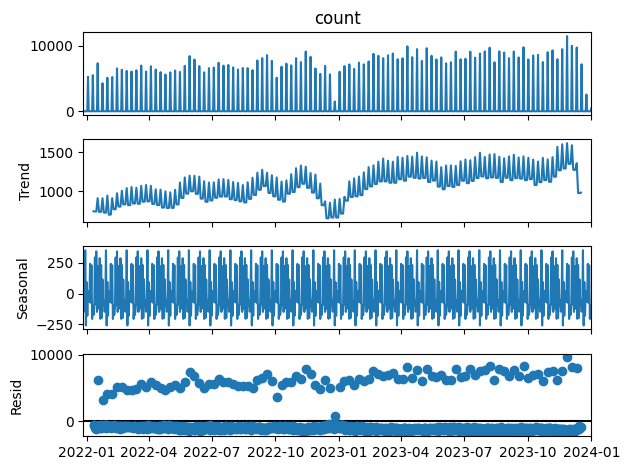

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_ts, model='additive', period=30)
fig = decomposition.plot()
plt.show()

#### daily data line plot

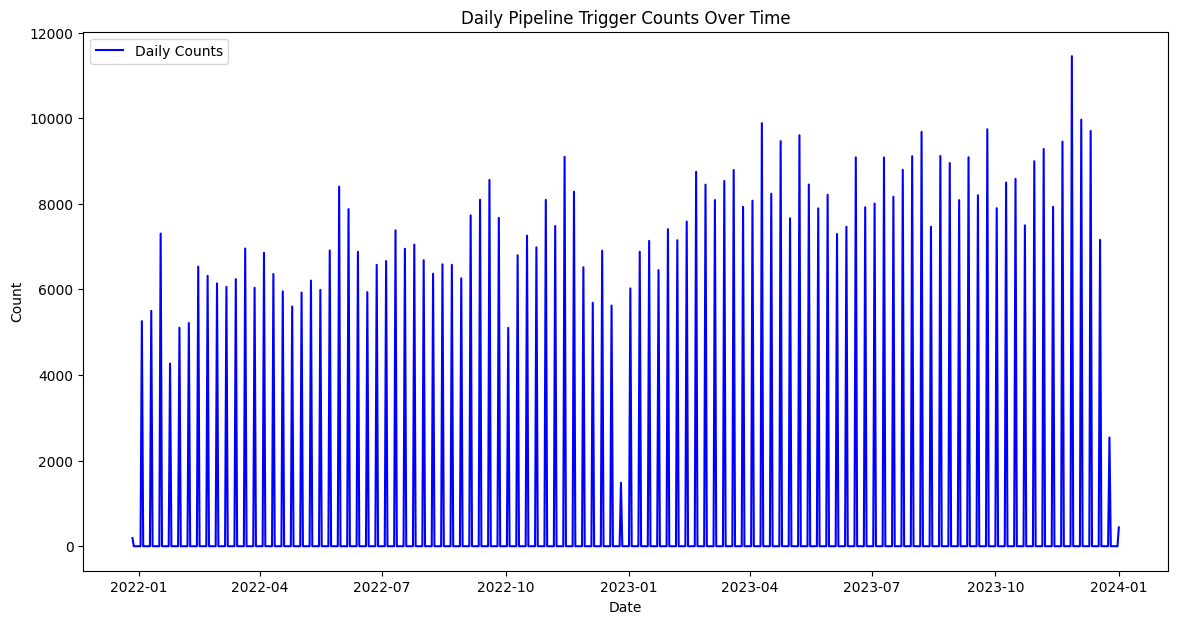

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(daily_ts, label='Daily Counts', color='blue')
plt.title('Daily Pipeline Trigger Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()


#### weekly data line point


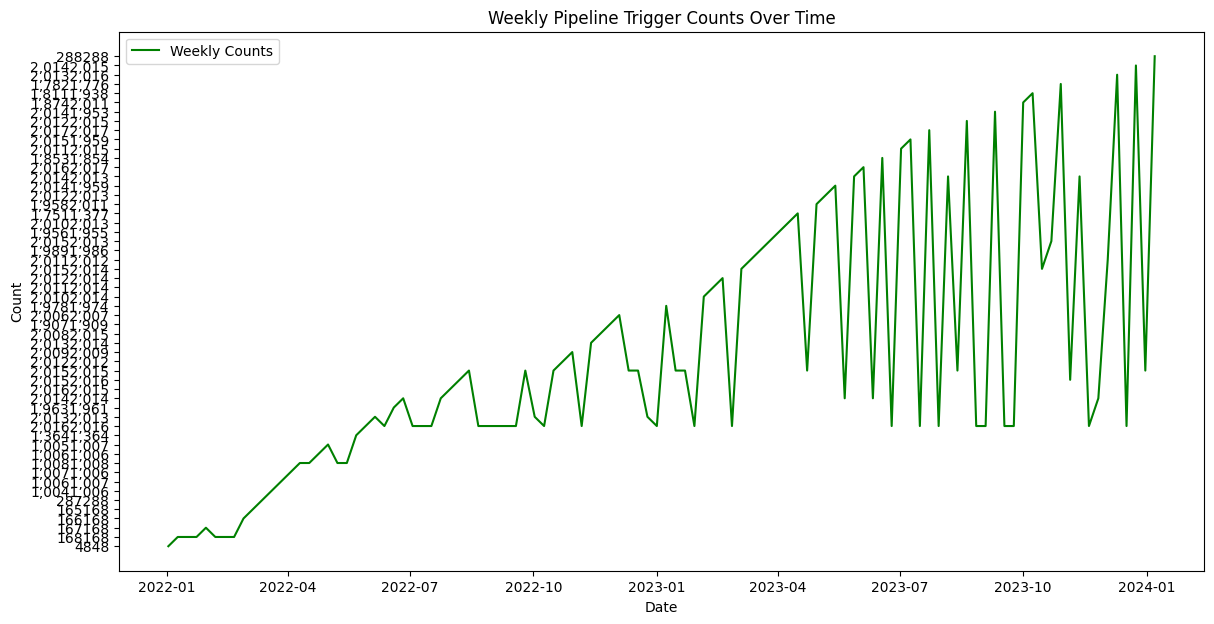

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(weekly_ts, label='Weekly Counts', color='green')
plt.title('Weekly Pipeline Trigger Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()


## Prophet TimeSeries Forecasting


In [12]:
# List of columns to convert
columns_to_convert = ['count', 'guaranteed_cpu_cores', 'used_cpu_cores', 'max_cpu_cores']

# Iterate over each column
for column in columns_to_convert:
    # Iterate over each row
    for index, row in weekly_combined.iterrows():
        value = row[column]
        # Check if the value is a string (has commas)
        if isinstance(value, str):
            # Remove commas and convert to integer
            converted_value = int(value.replace(',', ''))
            # Update the value in the DataFrame
            weekly_combined.at[index, column] = converted_value

print(weekly_combined)


           pipeline_id count available_cpu_cores  guaranteed_cpu_cores  \
timestamp                                                                
2021-12-27     Exec602    48                 632                   160   
2022-01-03     Exec602   168                 582                   160   
2022-01-10     Exec602   168                 616                   160   
2022-01-17     Exec602   168                 632                   160   
2022-01-24     Exec602   168                 624                   160   
...                ...   ...                 ...                   ...   
2023-12-04     Exec501  2016                 930                   320   
2023-12-11     Exec501  2016               1,054                   320   
2023-12-18     Exec501  2015               1,238                   320   
2023-12-25     Exec501  2015               1,254                   320   
2024-01-01     Exec501   288               1,212                   320   

            used_cpu_cores max_cpu_co

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4zwe088/v5ve1f5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4zwe088/9n9wrs8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20136', 'data', 'file=/tmp/tmp_4zwe088/v5ve1f5m.json', 'init=/tmp/tmp_4zwe088/9n9wrs8_.json', 'output', 'file=/tmp/tmp_4zwe088/prophet_modeldq3igf4q/prophet_model-20240605101038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:10:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


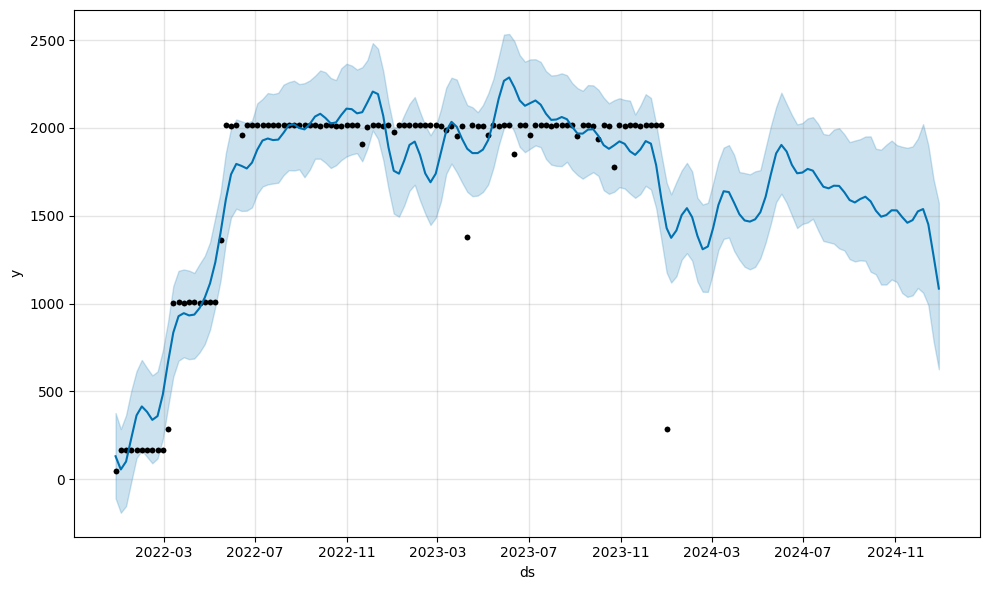

In [13]:

from prophet import Prophet
# Reset the index to make "timestamp" a regular column
weekly_combined.reset_index(inplace=True)

# Rename columns to match Prophet's requirements
weekly_combined.rename(columns={"timestamp": "ds", "count": "y"}, inplace=True)

# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(weekly_combined)

# Generate future dates for prediction
future = model.make_future_dataframe(periods=52, freq="W")

# Make predictions
forecast = model.predict(future)

# Visualize the forecasts
fig = model.plot(forecast)
fig.show()
